# **TOP1 clustering한 것과 개인정보를 후에 붙인 데이터 EDA 확인**  
# 1. 라이브러리 임포트 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# 한글 폰트 깨짐 방지

%matplotlib inline

import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
data = pd.read_csv('/content/drive/MyDrive/CARD-LANGCHAIN/data/Top1_clustering.csv')

# 2. 데이터 확인

In [4]:
data.head()

,남녀구분코드,연령,top1,Cluster,LifeStage
0,2,40대,납부,2,기혼
1,1,30대,쇼핑,0,기혼
2,2,40대,쇼핑,0,기혼
3,1,40대,교통,1,기혼
4,2,50대,납부,2,기혼


In [5]:
data['남녀구분코드'].replace(to_replace={2:'여성',1:'남성'},inplace=True)

<ipython-input-5-ba8929866789>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['남녀구분코드'].replace(to_replace={2:'여성',1:'남성'},inplace=True)


In [6]:
data.rename(columns={'남녀구분코드':'성별'},inplace=True)

<ipython-input-28-bea172443421>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= data, x='Cluster',palette='Paired')


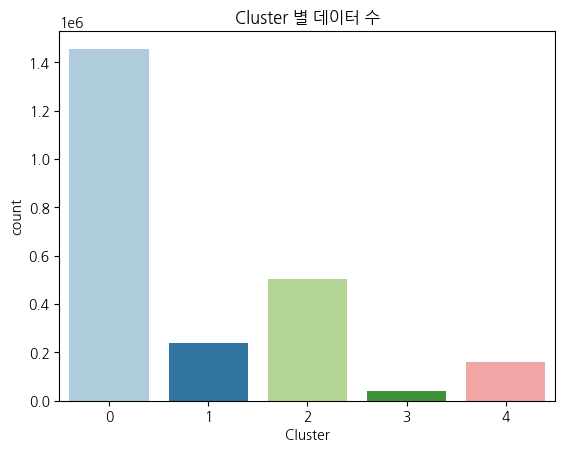

In [28]:
sns.countplot(data= data, x='Cluster',palette='Paired')
plt.title('Cluster 별 데이터 수')
plt.show()

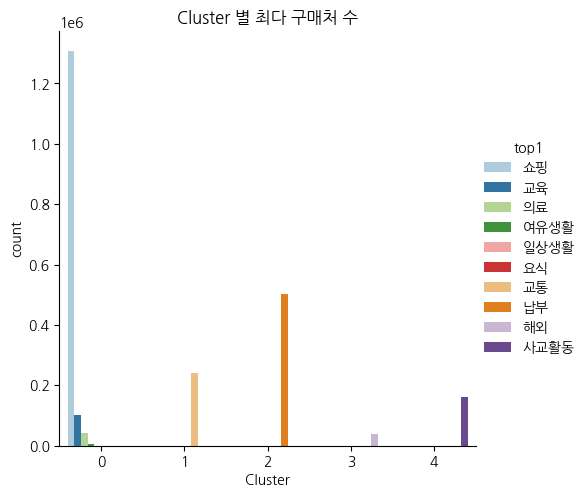

In [29]:
sns.catplot(kind='count',x='Cluster', hue='top1', data=data,palette = 'Paired')
plt.title('Cluster 별 최다 구매처 수')
plt.show()

In [ ]:
['쇼핑', '교육', '의료', '여유생활', '일상생활', '요식']
['교통']
['납부']
['해외']
['사교활동']

In [44]:
data.loc[data['Cluster'] == 0]['top1'].unique()

array(['쇼핑', '교육', '의료', '여유생활', '일상생활', '요식'], dtype=object)

In [45]:
data.loc[data['Cluster'] == 1]['top1'].unique()

array(['교통'], dtype=object)

In [46]:
data.loc[data['Cluster'] == 2]['top1'].unique()


array(['납부'], dtype=object)

In [47]:
data.loc[data['Cluster'] == 3]['top1'].unique()


array(['해외'], dtype=object)

In [48]:
data.loc[data['Cluster'] == 4]['top1'].unique()


array(['사교활동'], dtype=object)

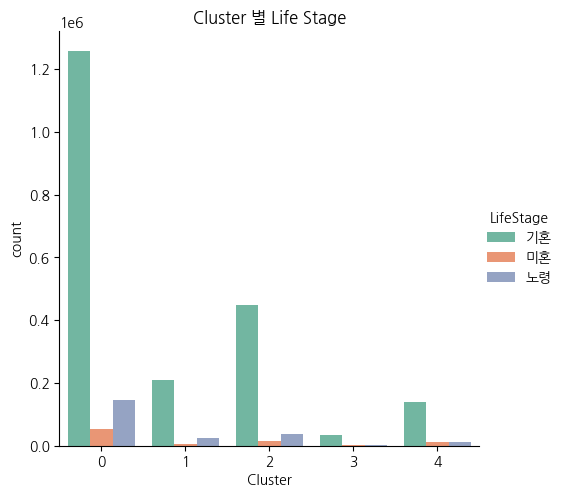

In [30]:
sns.catplot(kind='count',x='Cluster', hue='LifeStage', data=data,palette = 'Set2')
plt.title('Cluster 별 Life Stage')
plt.show()

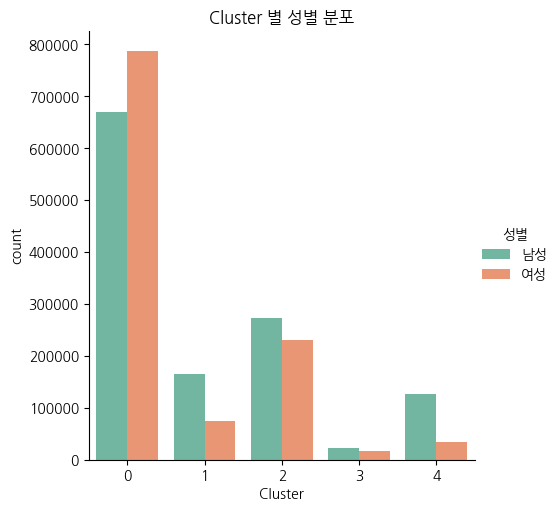

In [31]:
sns.catplot(kind='count',data=data, x='Cluster',hue='성별',palette = 'Set2')
plt.title('Cluster 별 성별 분포')
plt.show()

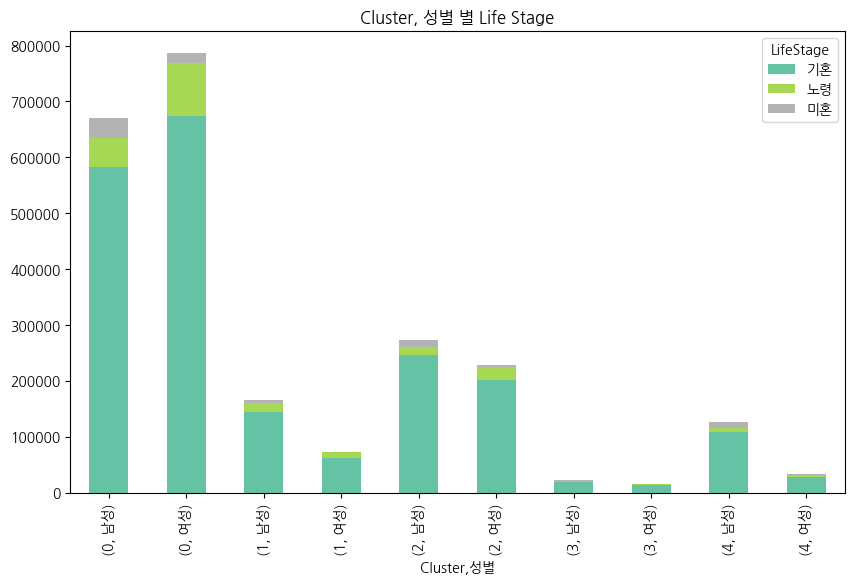

In [32]:
# 데이터 집계
grouped_data = data.groupby(['Cluster', '성별','LifeStage']).size().unstack(fill_value=0)

# stacked bar chart 그리기
grouped_data.plot(kind='bar', stacked=True, colormap='Set2',figsize=(10,6))

plt.title('Cluster, 성별 별 Life Stage')
plt.show()

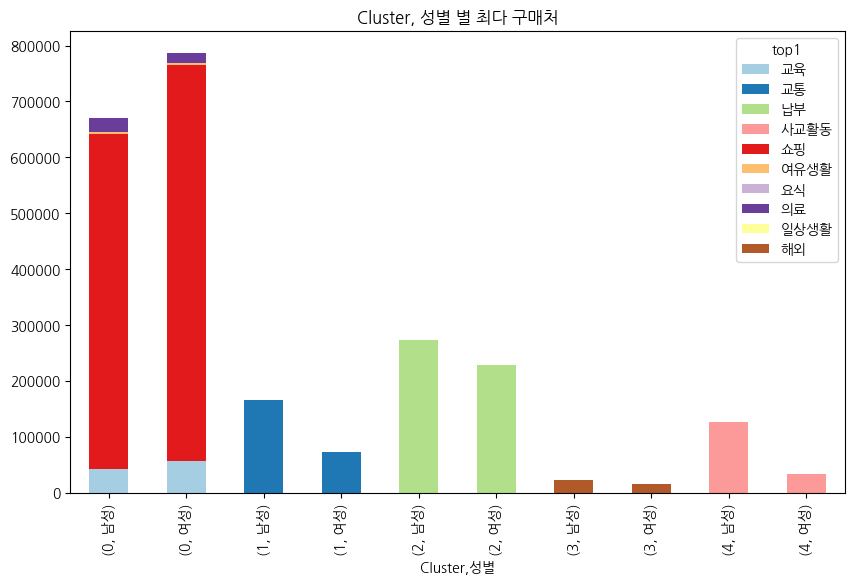

In [33]:
grouped_data = data.groupby(['Cluster','성별','top1']).size().unstack(fill_value=0)

grouped_data.plot(kind='bar', stacked=True, colormap='Paired',figsize=(10,6))

plt.title('Cluster, 성별 별 최다 구매처')
plt.show()

In [12]:
data.head()

,성별,연령,top1,Cluster,LifeStage
0,여성,40대,납부,2,기혼
1,남성,30대,쇼핑,0,기혼
2,여성,40대,쇼핑,0,기혼
3,남성,40대,교통,1,기혼
4,여성,50대,납부,2,기혼


### 변수들과의 상관관계

In [13]:
# 1. 더미변수로 라벨링

from sklearn import preprocessing
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for i in data.columns :
  data_encoded[i] = label.fit_transform(data[i])

data_encoded.head()

,성별,연령,top1,Cluster,LifeStage
0,1,2,2,2,0
1,0,1,4,0,0
2,1,2,4,0,0
3,0,2,1,1,0
4,1,3,2,2,0


In [14]:
# 함수 정의 및 혼동행렬 생성
from scipy.stats import chi2_contingency
def cramers_V(var1, var2):
  # Cross table building
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  # Keeping of the test statistic of the Chi2 test
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab) # Number of observations
  phi2 = stat / obs
  r, k = crosstab.shape
  phi2corr = max(0, phi2 - (((k-1)*(r-1))/(obs-1)))
  rcorr = r - ((r-1)**2)/(obs-1)
  kcorr = k - ((k-1)**2)/(obs-1)
  return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

rows = []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded:
    # Cramer's V test
    cramers = cramers_V(data_encoded[var1], data_encoded[var2])
    # Keeping of the rounded value of the Cramer's V
    col.append(round(cramers,2))
  rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns,  index=data_encoded.columns)

In [15]:
df

,성별,연령,top1,Cluster,LifeStage
성별,1.00,0.05,0.21,0.20,0.10
연령,0.05,1.00,0.11,0.05,0.76
top1,0.21,0.11,1.00,1.00,0.12
Cluster,0.20,0.05,1.00,1.00,0.05
LifeStage,0.10,0.76,0.12,0.05,1.00


In [16]:
# pip install numpy==1.23.1

<ipython-input-35-63ff6b483492>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


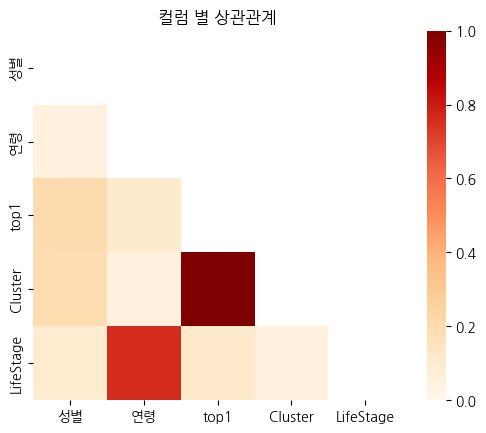

In [35]:
# 시각화
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df, mask=mask, vmin=0., vmax=1, square=True,cmap='OrRd')

plt.title('컬럼 별 상관관계')
plt.show()

In [37]:
data.shape

(2399344, 5)

In [38]:
data.drop_duplicates()

,성별,연령,top1,Cluster,LifeStage
0,여성,40대,납부,2,기혼
1,남성,30대,쇼핑,0,기혼
2,여성,40대,쇼핑,0,기혼
3,남성,40대,교통,1,기혼
4,여성,50대,납부,2,기혼
...,...,...,...,...,...
1603062,여성,30대,요식,0,기혼
1890358,남성,50대,납부,2,노령
1987236,여성,30대,납부,2,노령
2225988,남성,40대,사교활동,4,노령


In [39]:
df_top1_dropdupl = data.drop('Cluster',axis=1)

In [41]:
df_top1_dropdupl.drop_duplicates()

,성별,연령,top1,LifeStage
0,여성,40대,납부,기혼
1,남성,30대,쇼핑,기혼
2,여성,40대,쇼핑,기혼
3,남성,40대,교통,기혼
4,여성,50대,납부,기혼
...,...,...,...,...
1603062,여성,30대,요식,기혼
1890358,남성,50대,납부,노령
1987236,여성,30대,납부,노령
2225988,남성,40대,사교활동,노령


In [49]:
df_cluster_dropdupl = data.drop('top1',axis=1)
df_cluster_dropdupl.drop_duplicates(inplace=True)

In [57]:
df_cluster_dropdupl.loc[0]['연령']

'40대'

In [58]:
top1_category = {
    0 : ['쇼핑', '교육', '의료', '여유생활', '일상생활', '요식'],
    1 : ['교통'],
    2 : ['납부'],
    3 : ['해외'],
    4 : ['사교활동']}

In [59]:
df_cluster_dropdupl['Desribe'] = df_cluster_dropdupl['Cluster'].map(lambda x: ', '.join(top1_category.get(x,[])) )

df_cluster_dropdupl

,성별,연령,Cluster,LifeStage,Desribe
0,여성,40대,2,기혼,납부
1,남성,30대,0,기혼,"쇼핑, 교육, 의료, 여유생활, 일상생활, 요식"
2,여성,40대,0,기혼,"쇼핑, 교육, 의료, 여유생활, 일상생활, 요식"
3,남성,40대,1,기혼,교통
4,여성,50대,2,기혼,납부
...,...,...,...,...,...
1537809,남성,50대,1,노령,교통
1890358,남성,50대,2,노령,납부
1987236,여성,30대,2,노령,납부
2225988,남성,40대,4,노령,사교활동


In [63]:
unique_clusters_df = df_cluster_dropdupl.reset_index(drop=True)

In [64]:
unique_clusters_df

,성별,연령,Cluster,LifeStage,Desribe
0,여성,40대,2,기혼,납부
1,남성,30대,0,기혼,"쇼핑, 교육, 의료, 여유생활, 일상생활, 요식"
2,여성,40대,0,기혼,"쇼핑, 교육, 의료, 여유생활, 일상생활, 요식"
3,남성,40대,1,기혼,교통
4,여성,50대,2,기혼,납부
...,...,...,...,...,...
105,남성,50대,1,노령,교통
106,남성,50대,2,노령,납부
107,여성,30대,2,노령,납부
108,남성,40대,4,노령,사교활동


In [65]:
unique_clusters_df.to_csv('unique_clusters_df.csv',index=False)